In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1번. 97% 정확도 MNIST 분류기

In [2]:
# MNIST 데이터셋 불러오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
# 훈련 세트, 테스트 세트 나누기
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# KNeighborsClassifier 분류기 생성
# weights와 n_neighbors 하이퍼파라미터 그리드 탐색
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors':(3, 4, 5), 'weights':('uniform', 'distance')}

knn_base = KNeighborsClassifier()
grid_search = GridSearchCV(knn_base, parameters, cv=5)
grid_search.fit(X, y)

In [ ]:
grid_search.best_params_ # {'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
grid_search.best_score_ # 0.9716166666666666

In [ ]:
# 테스트 세트 97% 정확도 달성!
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred) # 0.9714

# 2번. 데이터 증식 (훈련 세트 확장)

In [4]:
# MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수 생성
from scipy.ndimage.interpolation import shift

def shift_image(image, down, right):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [right, down], cval=0, mode="constant")
    return shifted_image.reshape([-1])

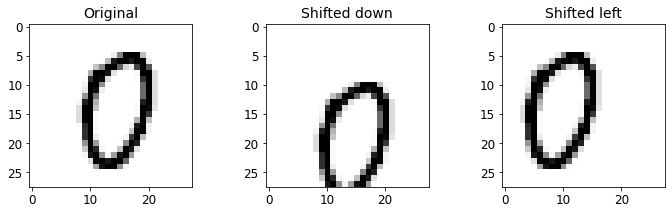

In [5]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5) # 오른쪽으로 5만큼 이동
shifted_image_left = shift_image(image, -5, 0) # 위쪽으로 5만큼 이동

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [6]:
# 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본(방향마다 한 개씩) 만들어 훈련 세트에 추가
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for down, right in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, down, right))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [7]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
# 확장된 데이터셋에서 1번의 최적 하이퍼파라미터 모델 훈련
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
KNeighborsClassifier(n_neighbors=4, weights='distance') # KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
# 테스트 세트에서 정확도 측정 -> 0.5% 성능 향상!
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred) # 0.9763